In [1]:
## Import neccessary packages 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from sklearn import svm
from tqdm import tqdm_notebook as tqdm
from random import shuffle
import itertools

In [30]:
# Initialize the Webcam
training_path = 'Media/M5/custom_training'
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW) 

# Create a named window
cv2.namedWindow("Train the Samples")

# Create a Counter
img_counter = 0

# Define all the Classes you want to classify with a space.
classes_string = 'a b'

# Now we will store each class seperately
classes = classes_string.split(' ')

# We are storing the ASCII values of all the letters in a new list. 
asci_values = [ord(item) for item in classes]

# These are all the special characters, Note: nothing asci value 9 is from the tab button.
special_case = [('del', 0)]

# Append the special values with their asci values.
for char, asci in special_case:
    asci_values.append(asci)
    classes.append(char)

#Initializing storage
storage = None

# Variable deciding whether to override previous saved samples
override = False

while True:
    
    ret, frame = cam.read()  
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
    
    # Taking ascii value of input key from user
    k = cv2.waitKey(1)
    
    # Check to make sure if the key that user pressed is among our classes
    if k in asci_values:
        
        # Now get the index of that class/letter from the ascii list.
        class_pos = asci_values.index(k)
        
        # Using the index get the associated class name/letter from the classes list.
        class_name = classes[class_pos].upper()
        
        # Extract the part of the frame where the hand is present
        #image = frame[1:230,380:620]
        image = frame[1:230,380:620]
        class_path = os.path.join(training_path, class_name)

        if not os.path.exists(class_path):
            os.mkdir(class_path)  
            
        # Reset the counter if you're now storing the samples of a different class.
        if storage != k:
            img_counter = 0
            
        # Adding samples vs Overriding them.
        if not override and img_counter == 0:
          if os.listdir(class_path):
            img_counter = max([int(img_name.replace(class_name,'').replace('.jpg','')) for img_name in os.listdir(class_path)])
            
        # Using the varibales above set up the image name.
        img_name = "{}{}.jpg".format(class_name, img_counter)

        # Save the image in folder named custom_training/<NAME_OF_CLASS>/  
        cv2.imwrite(os.path.join(training_path, '{}/{}'.format(class_name, img_name)), image)
        
        # Show the class name and the number of stored samples of the class
        cv2.putText(frame, "Class: {} , Sample Count: {}".format(class_name, img_counter), (10, 35),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
        
        
        # Remember the class we're taking samples of.
        storage = k
        
        # Increment the counter for every new sample
        img_counter += 1
    
    # Exit if Esc is pressed.
    elif k == 27: 
        break
    
    # Draw a rectangle to show where to make the hand gestures.
    cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
    
    #stacked = np.hstack((frame,asl_img))
    
    # Show the image
    cv2.imshow("Train the Samples", frame)
    
cam.release()
cv2.destroyAllWindows()    

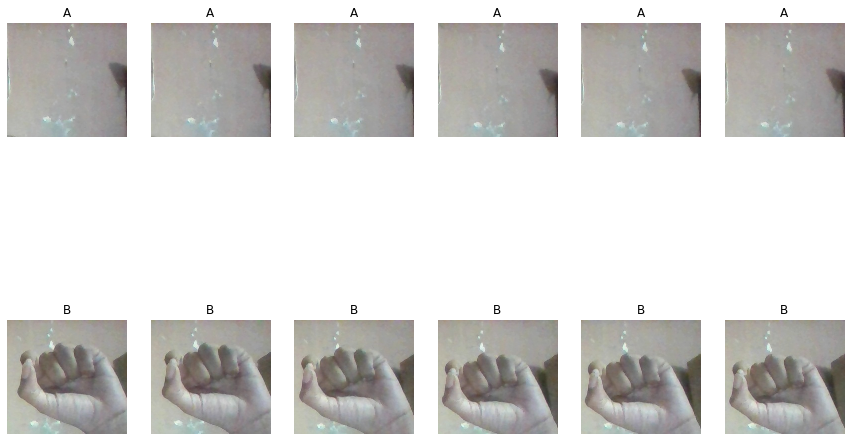

In [145]:
# Path for our training data.
training_path = 'Media/M5/custom_training'

# The names of our image classes are the names of sub folders.
train_classes = [directory for directory in os.listdir(training_path) if os.path.isdir(os.path.join(training_path,directory))]

plt.figure(figsize=[15,10])

rows = len(train_classes)

Img_no = 1
for class_name in train_classes:    
        img_list = os.listdir( os.path.join(training_path, class_name))[:6]
        for img in img_list:
            draw_image = cv2.imread(os.path.join(training_path, class_name, img),1)
            plt.subplot(rows, 6, Img_no);plt.imshow(draw_image[:,:,::-1]);plt.title(class_name);plt.axis('off');
            Img_no += 1

In [49]:
# Initialize hog parameters.
winSize = (64, 128) 
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1     # Has no effect 
winSigma = -1         # Going to be equal to 4
histogramNormType = 0 # h=Has no effect 
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64 
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, 
                        L2HysThreshold, gammaCorrection, nlevels, signedGradient)

In [146]:
train_classes

['A', 'B']

In [51]:
def getfeaturevectors(path, classes,  start_index = 0):
    # This list will hold the final feature vectors.
    Hog_feature_vectors = []
    n_Hog_feature_vectors= []
    
    # This list will hold the labels for each image.
    labels = []
    n_labels= []
    
    # This loop loops for each class (in total we have 29 classes for this dataset), we're also using tqdm for a progress bar.
    for class_label in tqdm(range(len(classes))):

            # This loop loops for each sample in each class (each class have approximately)
            for img in tqdm(os.listdir(os.path.join(path, classes[class_label]))[start_index:]):

                # Read the image
                image = cv2.imread(os.path.join(path, classes[class_label], img))

                # Resize the image, if the image is corrupted then leave it 
                try:
                    image = cv2.resize(image, (64, 128))
                    
                except:
                    #print('Error Readimg image {}'.format(os.path.join(path,classes[i], j)))
                    continue
                
                # Compute the descriptor            
                descriptor = hog.compute(image)

                # Store the feature vector and the label
                Hog_feature_vectors.append(descriptor)
                
                # Also store the label for each class
                if classes[class_label]=='A':
                    labels.append(0)
                else:
                    labels.append(1) 
                
    # Formatting labels as required.      
    n_labels = np.array(labels)
    
    # Formating hog feature vectors as required.
    n_Hog_feature_vectors = np.float32(Hog_feature_vectors).reshape(-1, len(Hog_feature_vectors[0]))
    
    # Print the total number of labels and hog features
    print('Total Descriptors: {} and Total Labels: {}'.format(len(Hog_feature_vectors), len(labels) ))
    
    # Return the feature vectors with their labels.
    return n_Hog_feature_vectors, n_labels

In [52]:
Hog_feature_vectors, labels = getfeaturevectors(training_path, train_classes)

C:\Users\Sadaf Zehra\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


C:\Users\Sadaf Zehra\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Total Descriptors: 1714 and Total Labels: 1714


In [53]:
model = cv2.ml.SVM_create()
model.setGamma(0)
model.setC(0.01)
model.setKernel(cv2.ml.SVM_LINEAR)
model.setType(cv2.ml.SVM_C_SVC)
model.setTermCriteria((cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-3))

In [54]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [55]:
# Training the model
model.train(Hog_feature_vectors, cv2.ml.ROW_SAMPLE, labels)

True

In [56]:
#model.save('Media/M5/svm_people.yml')
model.save('Media/M5/svm_people1.yml')

In [62]:
# load the model from disk
loaded_model =  cv2.ml.SVM_load('Media/M5/svm_people.yml')
#loaded_model =  cv2.ml.SVM_load('Media/M5/svm_people1.yml')

In [63]:
# This is the required pre-processing and formating required.

support_vectors = loaded_model.getSupportVectors()
rho, _ , _ = loaded_model.getDecisionFunction(0)
Detector = np.zeros(support_vectors.shape[1] + 1, dtype = support_vectors.dtype)
Detector[:-1] = - support_vectors[:]
Detector[-1] = rho

In [64]:
# Now we can pass the detector in the svm detector function.
hog.setSVMDetector(Detector)

In [143]:
def HandDetector(image,finalThreshold = 20, hitThreshold=1.7):
    
    Height = 310
    scale = Height / image.shape[0]
    image = cv2.resize(image, None, fx=scale, fy=scale)

    # Perform the Detection.
    boxes, weights = hog.detectMultiScale(image, winStride=(8, 8), padding=(32, 32), scale=1.02, 
                                         finalThreshold = finalThreshold, hitThreshold= hitThreshold)

    # Draw the Detected Boxes.
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x+w, y+h),(0, 255, 0), 5)
    
    # Either return the image or Plot it.
    plt.figure(figsize=[15,10])
    plt.imshow(image[:,:,::-1]);plt.axis('off');

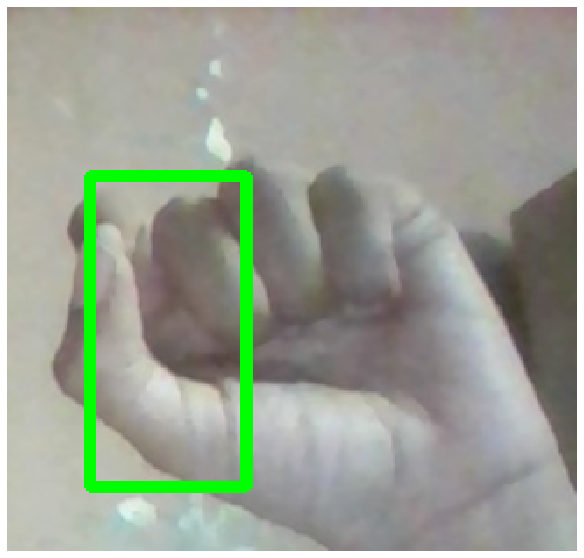

In [144]:
image = cv2.imread("Media/M5/custom_training/B/B152.jpg")
#print(image)
HandDetector(image);